In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from tqdm.notebook import trange

# Linear Algebra

# Comparison between Ordinary and Lazy PageRank

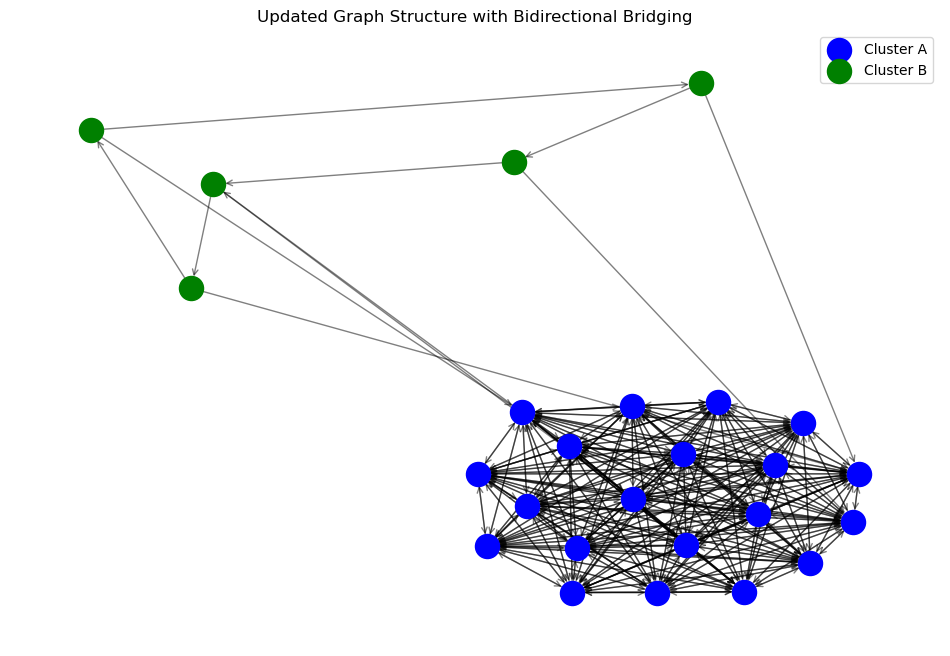

In [2]:
# Create an empty directed graph
G = nx.DiGraph()

# Cluster A: Dense SCC with 20 nodes
cluster_a_nodes = range(1, 21)
G.add_nodes_from(cluster_a_nodes)

# Add edges to make Cluster A strongly connected
for node in cluster_a_nodes:
    for target in cluster_a_nodes:
        if node != target:
            G.add_edge(node, target)

# Cluster B: Sparse component with 5 nodes
cluster_b_nodes = range(21, 26)
G.add_nodes_from(cluster_b_nodes)

# Add sparse edges within Cluster B (forming a ring)
for i in range(len(cluster_b_nodes)):
    G.add_edge(cluster_b_nodes[i], cluster_b_nodes[(i + 1) % len(cluster_b_nodes)])

# Bridging edges from Cluster B to Cluster A
for node in cluster_b_nodes:
    target = random.choice(list(cluster_a_nodes))
    G.add_edge(node, target)

# **New:** Bridging edges from Cluster A to Cluster B
for node in cluster_a_nodes:
    if random.random() < 0.1:  # 10% chance to add an edge to Cluster B
        target = random.choice(list(cluster_b_nodes))
        G.add_edge(node, target)

# Visualize the updated graph structure
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, nodelist=cluster_a_nodes, node_color='blue', label='Cluster A')
nx.draw_networkx_nodes(G, pos, nodelist=cluster_b_nodes, node_color='green', label='Cluster B')
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=10, alpha=0.5)
plt.title('Updated Graph Structure with Bidirectional Bridging')
plt.legend()
plt.axis('off')
plt.show()


In [3]:
# # Create a graph with characteristics where Lazy PageRank converges faster
# # 1. Include dangling nodes
# # 2. Disconnected components
# # 3. Strongly connected clusters

# # Initialize the graph
# G = nx.DiGraph()

# # Add a strongly connected cluster (component 1)
# G.add_edges_from([
#     (1, 2), (2, 3), (3, 4), (4, 1), (2, 4), (3, 1)
# ])

# # Add another strongly connected cluster (component 2)
# G.add_edges_from([
#     (5, 6), (6, 7), (7, 8), (8, 5), (6, 8), (7, 5)
# ])

# # Add dangling nodes connected to cluster 1
# G.add_edges_from([
#     (9, 1), (10, 2)
# ])

# # Add dangling nodes connected to cluster 2
# G.add_edges_from([
#     (11, 5), (12, 6)
# ])

# # Add disconnected nodes (dangling nodes with no outgoing edges)
# G.add_nodes_from([13, 14])

# # Visualize the graph
# pos = nx.spring_layout(G, seed=42)  # Position for consistent layout
# plt.figure(figsize=(10, 8))
# nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500, font_size=15)
# plt.title("Graph with Properties Favorable for Lazy PageRank")
# plt.show()


In [4]:
def power_iteration(P, alpha=0.85, max_iter=100, tol=1e-6):
    n = P.shape[0]
    r = np.ones(n) / n  # Initial rank vector
    residuals = []
    for i in range(max_iter):
        r_new = alpha * P.T @ r + (1 - alpha) / n
        residual = np.linalg.norm(r_new - r, 1)
        residuals.append(residual)
        if residual < tol:
            break
        r = r_new
    return r, residuals

def power_iteration_lazy(P, alpha=0.85, lazy_prob=0.5, max_iter=100, tol=1e-6):
    n = P.shape[0]
    r = np.ones(n) / n  # Initial rank vector
    residuals = []
    P_lazy = lazy_prob * np.eye(n) + (1 - lazy_prob) * P
    for i in range(max_iter):
        r_new = alpha * P_lazy.T @ r + (1 - alpha) / n
        residual = np.linalg.norm(r_new - r, 1)
        residuals.append(residual)
        if residual < tol:
            break
        r = r_new
    return r, residuals


In [5]:
# Get the adjacency matrix as a dense numpy array
A = nx.adjacency_matrix(G).astype(float).toarray()
n = A.shape[0]

# Compute row sums
row_sums = A.sum(axis=1)
dangling_nodes = (row_sums == 0)

# Avoid division by zero; replace zeros in row_sums
row_sums_fixed = row_sums.copy()
row_sums_fixed[dangling_nodes] = 1.0

# Normalize to create transition matrix P
P = A / row_sums_fixed[:, np.newaxis]

# For dangling nodes, set rows to uniform probability
P[dangling_nodes, :] = 1.0 / n

# Ordinary PageRank
pr_ordinary, residuals_ordinary = power_iteration(P)

# Lazy PageRank
pr_lazy, residuals_lazy = power_iteration_lazy(P, lazy_prob=0.5)


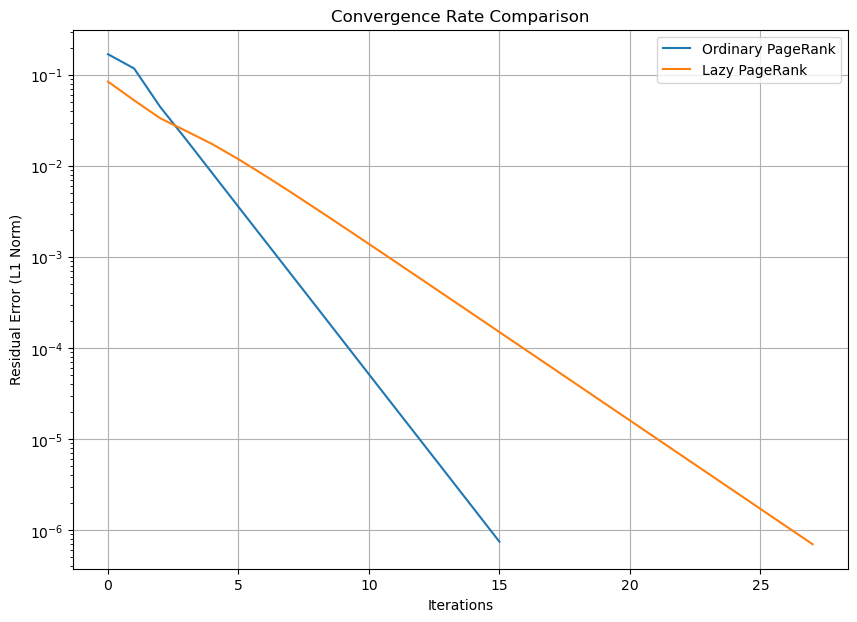

In [6]:
plt.figure(figsize=(10, 7))
plt.plot(residuals_ordinary, label='Ordinary PageRank')
plt.plot(residuals_lazy, label='Lazy PageRank')
plt.xlabel('Iterations')
plt.ylabel('Residual Error (L1 Norm)')
plt.title('Convergence Rate Comparison')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


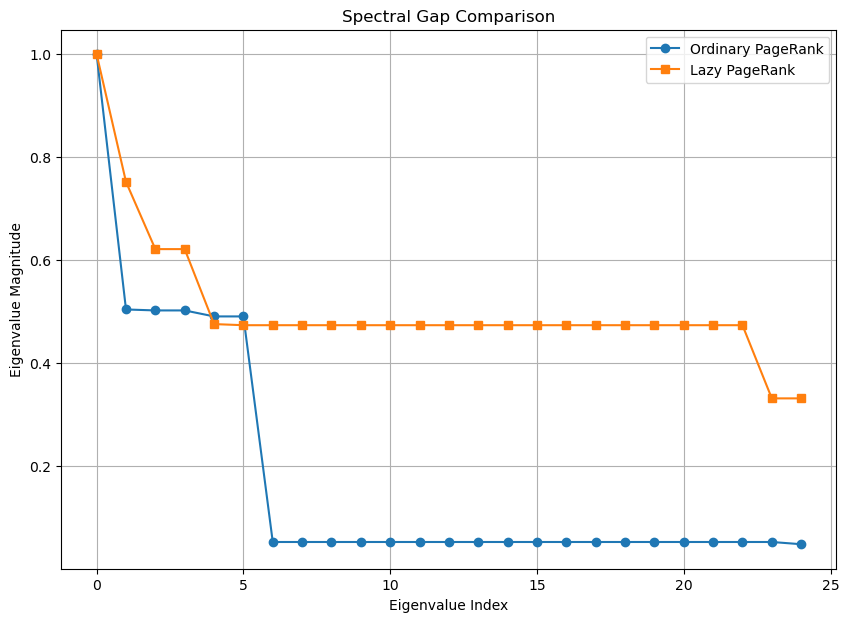

In [7]:
# Ordinary Transition Matrix
eigvals_ordinary = np.linalg.eigvals(P.T)

# Lazy Transition Matrix
P_lazy = 0.5 * np.eye(n) + 0.5 * P
eigvals_lazy = np.linalg.eigvals(P_lazy.T)

# Sort eigenvalues in descending order
eigvals_ordinary = np.sort(np.abs(eigvals_ordinary))[::-1]
eigvals_lazy = np.sort(np.abs(eigvals_lazy))[::-1]

# Plot the eigenvalues
plt.figure(figsize=(10, 7))
plt.plot(eigvals_ordinary.real, marker='o', label='Ordinary PageRank')
plt.plot(eigvals_lazy.real, marker='s', label='Lazy PageRank')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude')
plt.title('Spectral Gap Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
def simulate_hitting_time(G, start_node, target_node, num_simulations=1000, max_steps=1000):
    hitting_times = []
    for _ in trange(num_simulations, desc="Simulating Ordinary Hitting Times"):
        current_node = start_node
        steps = 0
        while current_node != target_node and steps < max_steps:
            steps += 1
            neighbors = list(G.successors(current_node))
            if not neighbors:
                break  # Dead end
            current_node = random.choice(neighbors)
        if current_node == target_node:
            hitting_times.append(steps)
        else:
            hitting_times.append(max_steps)  # Assign max_steps if target not reached
    return np.mean(hitting_times), np.std(hitting_times)

def simulate_hitting_time_lazy(G, start_node, target_node, lazy_prob=0.5, num_simulations=1000, max_steps=1000):
    hitting_times = []
    for _ in trange(num_simulations, desc="Simulating Lazy Hitting Times"):
        current_node = start_node
        steps = 0
        while current_node != target_node and steps < max_steps:
            steps += 1
            if random.random() < lazy_prob:
                continue  # Stay at the same node
            neighbors = list(G.successors(current_node))
            if not neighbors:
                break  # Dead end
            current_node = random.choice(neighbors)
        if current_node == target_node:
            hitting_times.append(steps)
        else:
            hitting_times.append(max_steps)  # Assign max_steps if target not reached
    return np.mean(hitting_times), np.std(hitting_times)


In [9]:
# Function to check mutual reachability
def are_mutually_reachable(G, node1, node2):
    return nx.has_path(G, node1, node2) and nx.has_path(G, node2, node1)

# Select node pairs that are mutually reachable
def select_mutually_reachable_pair(G, cluster_a_nodes, cluster_b_nodes):
    while True:
        node_a = random.choice(list(cluster_a_nodes))
        node_b = random.choice(list(cluster_b_nodes))
        if are_mutually_reachable(G, node_a, node_b):
            return node_a, node_b

# Select a valid node pair
node_a, node_b = select_mutually_reachable_pair(G, cluster_a_nodes, cluster_b_nodes)
print(f"Selected Node A: {node_a} (Cluster A), Node B: {node_b} (Cluster B)")


Selected Node A: 20 (Cluster A), Node B: 25 (Cluster B)


Simulating Ordinary Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Ordinary Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Lazy Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Lazy Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

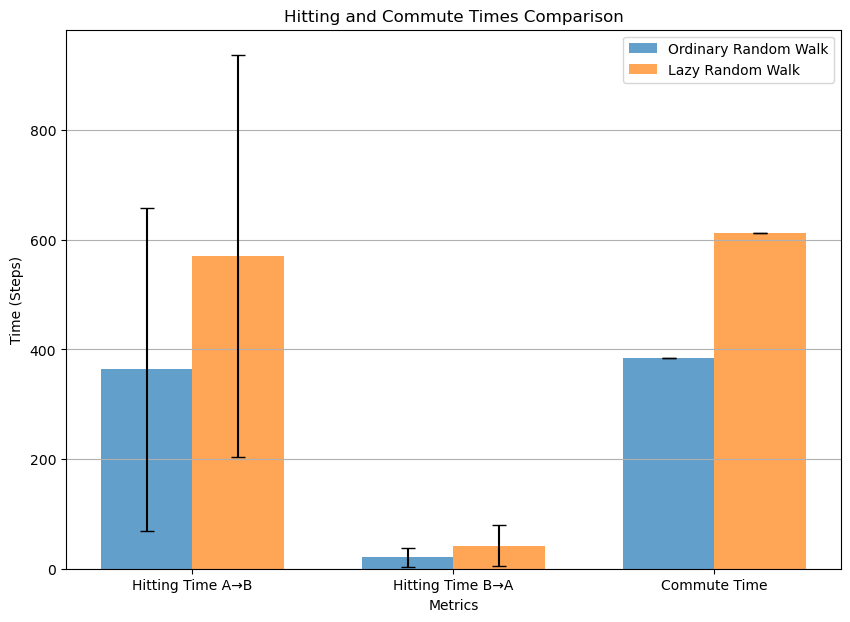

In [10]:
# Compute Hitting and Commute Times

# Ordinary Random Walk
hitting_time_ab_ord, std_ab_ord = simulate_hitting_time(G, node_a, node_b)
hitting_time_ba_ord, std_ba_ord = simulate_hitting_time(G, node_b, node_a)
commute_time_ord = hitting_time_ab_ord + hitting_time_ba_ord

# Lazy Random Walk
hitting_time_ab_lazy, std_ab_lazy = simulate_hitting_time_lazy(G, node_a, node_b, lazy_prob=0.5)
hitting_time_ba_lazy, std_ba_lazy = simulate_hitting_time_lazy(G, node_b, node_a, lazy_prob=0.5)
commute_time_lazy = hitting_time_ab_lazy + hitting_time_ba_lazy

# Prepare Data for Plotting
labels = ['Hitting Time A→B', 'Hitting Time B→A', 'Commute Time']
ordinary_times = [hitting_time_ab_ord, hitting_time_ba_ord, commute_time_ord]
lazy_times = [hitting_time_ab_lazy, hitting_time_ba_lazy, commute_time_lazy]
ordinary_std = [std_ab_ord, std_ba_ord, 0]  # Assuming std for commute_time_ord is negligible
lazy_std = [std_ab_lazy, std_ba_lazy, 0]    # Assuming std for commute_time_lazy is negligible

x = np.arange(len(labels))
width = 0.35  # Width of the bars

# Plotting the Results
plt.figure(figsize=(10, 7))
plt.bar(x - width/2, ordinary_times, width, yerr=ordinary_std, capsize=5, label='Ordinary Random Walk', alpha=0.7)
plt.bar(x + width/2, lazy_times, width, yerr=lazy_std, capsize=5, label='Lazy Random Walk', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Time (Steps)')
plt.title('Hitting and Commute Times Comparison')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y')
plt.show()


Simulating walks starting from Node 21 (Cluster B)


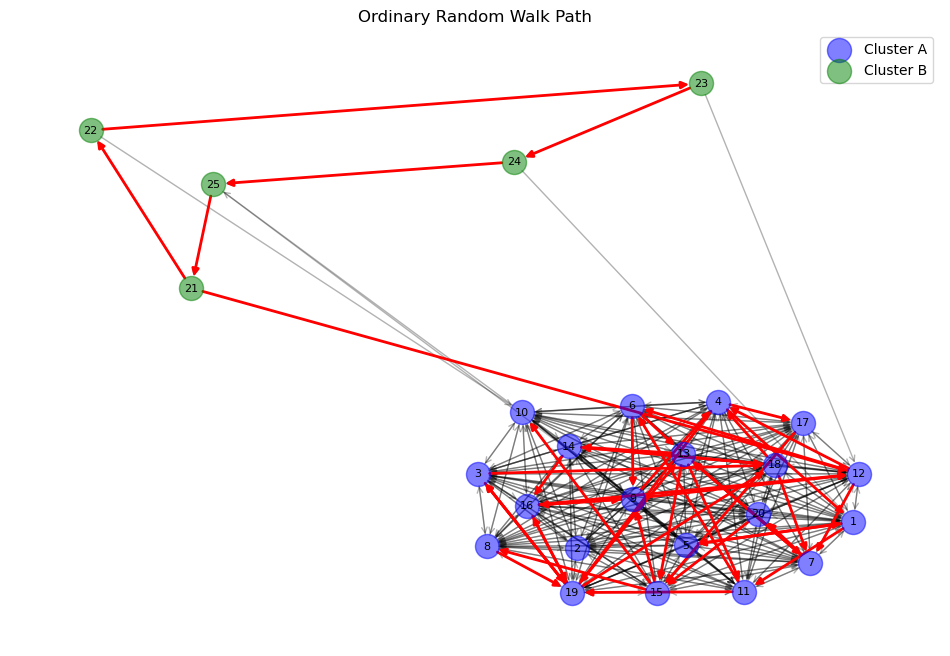

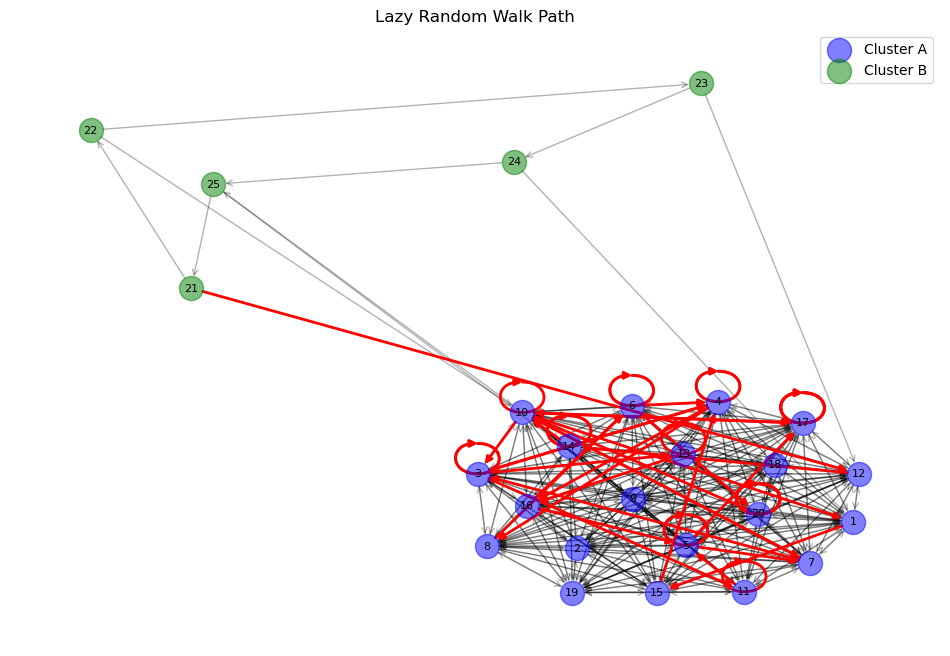

In [11]:
def simulate_random_walk(G, start_node, steps=50):
    path = [start_node]
    current_node = start_node
    for _ in range(steps):
        neighbors = list(G.successors(current_node))
        if not neighbors:
            break
        current_node = random.choice(neighbors)
        path.append(current_node)
    return path

def simulate_random_walk_lazy(G, start_node, lazy_prob=0.5, steps=50):
    path = [start_node]
    current_node = start_node
    for _ in range(steps):
        if random.random() < lazy_prob:
            path.append(current_node)  # Stay at the same node
            continue
        neighbors = list(G.successors(current_node))
        if not neighbors:
            break
        current_node = random.choice(neighbors)
        path.append(current_node)
    return path

# Select a start node from Cluster B
start_node = random.choice(list(cluster_b_nodes))
print(f"Simulating walks starting from Node {start_node} (Cluster B)")

# Simulate Ordinary Random Walk
path_ord = simulate_random_walk(G, start_node)

# Simulate Lazy Random Walk
path_lazy = simulate_random_walk_lazy(G, start_node, lazy_prob=0.5)

# Function to highlight paths on the graph
def plot_walk_path(G, path, title):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, nodelist=cluster_a_nodes, node_color='blue', alpha=0.5, label='Cluster A')
    nx.draw_networkx_nodes(G, pos, nodelist=cluster_b_nodes, node_color='green', alpha=0.5, label='Cluster B')
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=10, alpha=0.3)
    # Highlight the path
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2, arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(title)
    plt.legend()
    plt.axis('off')
    plt.show()

# Plotting the paths
plot_walk_path(G, path_ord, 'Ordinary Random Walk Path')
plot_walk_path(G, path_lazy, 'Lazy Random Walk Path')


Why Did Ordinary PageRank Converge Faster in Graph 1?

- **Graph Structure**: The graph had strong connectivity within Cluster A and sparse connectivity in Cluster B, with bidirectional bridging edges.

- **Impact on Random Walks**: In such a graph, the ordinary random walk moves quickly due to high connectivity, especially within Cluster A.

- **Lazy Random Walk Effect**: Introducing laziness (probability of staying at the same node) can slow down the convergence in graphs that are already well-connected because it reduces the movement across nodes.

Why Did Lazy PageRank Converge Faster in Graph 2?

- **Dangling Nodes (9, 10, 11, 12, 13, 14):** Lazy PageRank mitigates the need to redistribute ranks uniformly across the graph, reducing global computation.

- **Disconnected Components ({1, 2, 3, 4} and {5, 6, 7, 8}):** Lazy PageRank keeps rank localized longer within components, accelerating local convergence.

- **Strong Local Clusters:** Nodes within clusters (e.g., {1, 2, 3, 4}) strongly reinforce ranks among themselves, stabilizing faster in Lazy PageRank due to reduced inter-cluster rank dispersion.

- **Reduced Teleportation Effect:** Lazy PageRank limits excessive jumping to unrelated nodes, allowing ranks to stabilize more efficiently in dense substructures.

In a simple random walk on a graph, the transition probability from node $ i $ to node $ j $ is given by the transition matrix $ P $, where $ P_{ij} = \frac{1}{\text{deg}(i)} $ if there is an edge between $ i $ and $ j $, and 0 otherwise. This means that at each time step $ t $, the probability distribution $ \pi_t $ evolves according to:

$
\pi_{t+1} = \pi_t P.
$

In a lazy random walk, the walker has a probability $ \alpha $ of staying at the current node and a probability $ (1 - \alpha) $ of moving to a neighboring node. The transition matrix $ P_{\text{lazy}} $ for the lazy random walk is therefore:

$
P_{\text{lazy}} = \alpha I + (1 - \alpha) P,
$

where $ I $ is the identity matrix. This modification introduces self-loops at each node with probability $ \alpha $.

At time $ t+1 $, the probability distribution $ \pi_{t+1} $ in the lazy random walk evolves as:

$
\pi_{t+1} = \pi_t P_{\text{lazy}} = \alpha \pi_t I + (1 - \alpha) \pi_t P = \alpha \pi_t + (1 - \alpha) \pi_t P.
$

**Observation:** The key difference between the lazy random walk and the simple random walk is the inclusion of the term $ \alpha \pi_t $, representing the probability of the walker staying at the current node. This self-loop slows down the convergence of the walk compared to the simple random walk because the probability distribution changes more gradually over time.

---


Given the PageRank transition matrix:

$
P_g = (1 - p) P + p B,
$

where $ P $ is a stochastic matrix, $ B = \frac{1}{n} \mathbf{1}_{n \times n} $ is a matrix where each entry is $ \frac{1}{n} $, and $ p $ is the damping factor (typically $ p = 0.15 $).

To prove that $ P_g $ remains stochastic, we need to show two things:

1. **Non-negativity:** All entries of $ P_g $ are non-negative.
2. **Row sums equal to 1:** The sum of each row in $ P_g $ is 1.

**Proof:**

1. **Non-negativity:**
   - Since $ P $ is stochastic, $ P_{ij} \geq 0 $ for all $ i, j $.
   - Since $ B_{ij} = \frac{1}{n} \geq 0 $ for all $ i, j $.
   - The coefficients $ (1 - p) $ and $ p $ are non-negative (since $ p \in [0,1] $).
   - Therefore, $ P_g $ entries are non-negative:
     $
     P_g[i][j] = (1 - p) P[i][j] + p B[i][j] \geq 0.
     $

2. **Row sums equal to 1:**
   - For each row $ i $:
     $
     \sum_{j} P_g[i][j] = (1 - p) \sum_{j} P[i][j] + p \sum_{j} B[i][j].
     $
   - Since $ P $ is stochastic:
     $
     \sum_{j} P[i][j] = 1.
     $
   - Since $ B[i][j] = \frac{1}{n} $:
     $
     \sum_{j} B[i][j] = n \times \frac{1}{n} = 1.
     $
   - Therefore:
     $
     \sum_{j} P_g[i][j] = (1 - p)(1) + p(1) = 1.
     $

**Conclusion:** Since $ P_g $ has non-negative entries and each row sums to 1, $ P_g $ remains a stochastic matrix.

In [12]:
def vector_norm(x, p=2):
    return np.linalg.norm(x, p)

def dot_product(x, y):
    return np.dot(x, y)

def cross_product(x, y):
    return np.cross(x, y)

def transpose(x):
    return x.T

def multiply(x, y):
    return x @ y

def determinant(x):
    return np.linalg.det(x)

def inverse(x):
    return np.linalg.inv(x)

def compute_eigenvectors(x):
    vals, vecs = np.linalg.eig(x)
    return vals, vecs

def diagonalize(x):
    eigenvalues, eigenvectors = eigenvectors(x)
    D = np.diag(eigenvalues)
    eigenvectors_inv = inverse(eigenvectors)
    return eigenvectors, D, eigenvectors_inv

def is_orthogonal(x):
    return np.allclose(x @ x.T, np.eye(x.shape[0]))

def is_symmetric(x):
    return np.allclose(x, x.T)

def is_positive_semi_definite(x):
    return np.all(np.linalg.eigvals(x) >= 0)

def is_positive_definite(x):
    return np.all(np.linalg.eigvals(x) > 0)

def rank(x):
    return np.linalg.matrix_rank(x)

def sum_of_eigenvalues(x):
    return np.trace(x)

def product_of_eigenvalues(x):
    return determinant(x)

## Question 1

What could you say about these matrices: 
$$
\begin{pmatrix} -1 & \dfrac{3}{2} \\ 1 & -1 \end{pmatrix}
\begin{pmatrix} -1 & \dfrac{3}{2} \\ \dfrac{2}{3} & -1 \end{pmatrix}
\begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}
$$

### Code

In [13]:
A = np.array([[-1, 3/2], [1, -1]])
B = np.array([[-1, 3/2], [2/3, -1]])
C = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

determinant_A = determinant(A)
determinant_B = determinant(B)
determinant_C = determinant(C)

print(f'Determinant of A: {determinant_A}')
print(f'Determinant of B: {determinant_B}')
print(f'Determinant of C: {determinant_C}')
print()

eigenvalues_A, eigenvectors_A = compute_eigenvectors(A)
eigenvalues_B, eigenvectors_B = compute_eigenvectors(B)
eigenvalues_C, eigenvectors_C = compute_eigenvectors(C)

print(f'Eigenvalues of A: {eigenvalues_A}')
print(f'Eigenvectors of A:\n{eigenvectors_A}\n')

print(f'Eigenvalues of B: {eigenvalues_B}')
print(f'Eigenvectors of B:\n{eigenvectors_B}\n')

print(f'Eigenvalues of C: {eigenvalues_C}')
print(f'Eigenvectors of C:\n{eigenvectors_C}\n')

transpose_A = transpose(A)
transpose_B = transpose(B)
transpose_C = transpose(C)

print(f'Transpose of A:\n{transpose_A}\n')
print(f'Transpose of B:\n{transpose_B}\n')
print(f'Transpose of C:\n{transpose_C}\n')

Determinant of A: -0.5
Determinant of B: 0.0
Determinant of C: 1.0

Eigenvalues of A: [ 0.22474487 -2.22474487]
Eigenvectors of A:
[[ 0.77459667 -0.77459667]
 [ 0.63245553  0.63245553]]

Eigenvalues of B: [-1.11022302e-16 -2.00000000e+00]
Eigenvectors of B:
[[ 0.83205029 -0.83205029]
 [ 0.5547002   0.5547002 ]]

Eigenvalues of C: [1. 1. 1.]
Eigenvectors of C:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Transpose of A:
[[-1.   1. ]
 [ 1.5 -1. ]]

Transpose of B:
[[-1.          0.66666667]
 [ 1.5        -1.        ]]

Transpose of C:
[[1 0 0]
 [0 1 0]
 [0 0 1]]



### Formalization

**Properties of A**

- Non-zero determinant means that it is invertible and it is full-rank
- It has real and distinct eigenvalues, so it is diagonalizable
- It is not symmetric
- It is orthogonal

**Properties of B**

- Zero determinant means that it is not invertible and it is not full-rank
- Multiplying it with A will result in a non-invertible matrix as well
- It has real and distinct eigenvalues, so it is diagonalizable
- It is not symmetric
- Rank = 1 since there is just one non-zero eigenvalue

**Properties of C**

- It is an identity matrix of size 3x3
- It has a non-zero determinant, so it is invertible and full-rank
- It has real and distinct eigenvalues, so it is diagonalizable
- It is already diagonalized


| Property       | **Matrix A**                    | **Matrix B**                     | **Matrix C**             |
|----------------|---------------------------------|----------------------------------|--------------------------|
| **Size**       | 2 $\times$ 2                  | $2 \times 2$                   | $3 \times 3$           |
| **Determinant**| $-\dfrac{1}{2}$ (invertible)  | $0$ (singular)                 | $1$ (invertible)       |
| **Eigenvalues**| $-1 \pm \dfrac{\sqrt{6}}{2}$  | $0$ and $-2$                 | $1$, $1$, $1$      |
| **Symmetric**  | No                              | No                               | Yes                      |
| **Diagonalizable**| Yes (distinct eigenvalues)   | Yes (distinct eigenvalues)       | Yes (already diagonal)   |
| **Rank**       | $2$ (full rank)               | $1$                            | $3$ (full rank)        |
| **Orthogonal** | No                              | No                               | Yes                      |

## Question 2. 

Prove that $A^n = X\Lambda ^n X^{−1}$

### Formalization

Assuming A in invertible, we prove this by induction. 

For n=1 its given since 
$$A^1 = X\Lambda ^1 X^{−1} \rightarrow A = X\Lambda X^{−1}$$


Assuming the property holds for n (that is  $A^n = X\Lambda ^n X^{−1}$), we prove it for (n+1)
$$A^{n+1} = A^n\times A $$
by induction hypothesis
$$ = X\Lambda ^n X^{−1} \times X\Lambda X^{−1}  = X\Lambda ^{n+1} X^{−1} $$
**QED**

We can show this is the case for an example matrix.

### Code

In [14]:
# Matrices with determinant 1 have integer inverses
eigenvectors = np.array([
    [1, 2, 3, 2],
    [0, 1, 4, 3],
    [0, 0, 1, 2],
    [0, 0, 0, 1]
])
# Permute rows to make it look a bit more interesting
eigenvectors= eigenvectors[[2,0,3,1]]

eigenvalues = np.diag([5,4,3,9])

# Now we have an matrix A
A = eigenvectors@eigenvalues@np.linalg.inv(eigenvectors)
A

array([[ 3.,  0., 12.,  0.],
       [ 2.,  5., 10., -2.],
       [ 0.,  0.,  9.,  0.],
       [-4.,  0., 23.,  4.]])

In [15]:
A5 = np.linalg.matrix_power(A, 5)
# You can use the property that A^n = X*Lambda^n*X^-1
A5_eigenvectors = eigenvectors @ np.diag([5**5, 4**5, 3**5, 9**5]) @ np.linalg.inv(eigenvectors)

print("Are the two matrices the same?: ", (A5 == A5_eigenvectors).all())

Are the two matrices the same?:  True


## Question 3

Find the eigenvalues and unit eigenvectors of $A^TA$ and $AA^T$ with A = $\begin{pmatrix} 1 & 1 \\ 1 & 0 \end{pmatrix}$ Fibonacci matrix

### Code

In [16]:
A = np.array([[1, 1], [1, 0]])

ata = multiply(transpose(A), A)
aat = multiply(A, transpose(A))

print(f'A^T @ A:\n{ata}\n')
print(f'A @ A^T:\n{aat}\n')

eigenvalues_ata, eigenvectors_ata = compute_eigenvectors(ata)
eigenvalues_aat, eigenvectors_aat = compute_eigenvectors(aat)

print(f'Eigenvalues of A^T @ A: {eigenvalues_ata}')
print(f'Unit eigenvectors of A^T @ A:\n{eigenvectors_ata}\n')

print(f'Eigenvalues of A @ A^T: {eigenvalues_aat}')
print(f'Unit eigenvectors of A @ A^T:\n{eigenvectors_aat}\n')

A^T @ A:
[[2 1]
 [1 1]]

A @ A^T:
[[2 1]
 [1 1]]

Eigenvalues of A^T @ A: [2.61803399 0.38196601]
Unit eigenvectors of A^T @ A:
[[ 0.85065081 -0.52573111]
 [ 0.52573111  0.85065081]]

Eigenvalues of A @ A^T: [2.61803399 0.38196601]
Unit eigenvectors of A @ A^T:
[[ 0.85065081 -0.52573111]
 [ 0.52573111  0.85065081]]



### **Formalization**


In this case, $ A^T A $ and $ A A^T $ are **identical** because $ A $ is a **symmetric matrix** ($ A = A^T $).


- **Symmetry:**
  - Both $ A^T A $ and $ A A^T $ are **symmetric matrices**. This implies that they have real eigenvalues and their eigenvectors are orthogonal.

- **Positive Semi-Definiteness:**
  - Since $ A^T A $ and $ A A^T $ are formed by the product of a matrix with its transpose, they are **positive semi-definite**. Given that $ A $ is invertible (determinant $ \det(A) = -1 \neq 0 $), $ A^T A $ and $ A A^T $ are actually **positive definite**.

- **Eigenvalues:**
  - Both matrices share the **same eigenvalues** because they are similar matrices (i.e., $ A^T A $ and $ A A^T $ have the same non-zero eigenvalues).
  
- **Eigenvectors:**
  - The **unit eigenvectors** of $ A^T A $ and $ A A^T $ are identical in this case due to the symmetry and identical nature of the two matrices.
  - The eigenvectors are orthonormal, meaning they are both **unit vectors** and **mutually perpendicular**.

- **Diagonalization:**
  - Being symmetric and positive definite, both $ A^T A $ and $ A A^T $ are **diagonalizable**.

## Question 4. 
Find determinants, eigenvector and eigen values 
Without multiplying 

$$
S = \begin{bmatrix}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta 
\end{bmatrix}
\begin{bmatrix}
2 & 0 \\
0 & 5 
\end{bmatrix}
\begin{bmatrix}
\cos \theta & \sin \theta \\
-\sin \theta & \cos \theta 
\end{bmatrix}
$$

find the determinant, the eigenvalues and eigenvectors, why S is positive definite

### Formalization

Let 
$$
S = \begin{bmatrix}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta 
\end{bmatrix}
\begin{bmatrix}
2 & 0 \\
0 & 5 
\end{bmatrix}
\begin{bmatrix}
\cos \theta & \sin \theta \\
-\sin \theta & \cos \theta 
\end{bmatrix}
$$

Then we know that $T_1 = \begin{bmatrix} \cos \theta & -\sin \theta \\ \sin \theta & \cos \theta \end{bmatrix}$  is a rotation matrix that rotates a vector $\theta$ degrees counterclockwise.

Similarly we have that $T_2 = \begin{bmatrix} \cos \theta & \sin \theta \\ -\sin \theta & \cos \theta \end{bmatrix}$ is a rotation matrix that rotates a vector $\theta$ degrees clockwise.

So by multiplying by $S$ what we are truly doing is rotating clockwise $\theta$, then multiplying by $E = \begin{bmatrix} 2 & 0 \\ 0 & 5 \end{bmatrix}$ which is expanding on the X and Y axis by 2 and 5 respectevly and then is rotating everything counterclockwise $\theta$ degrees.

For the **determinant** it is easy to see that $T_1$ and $T_2$ are ortogonal and have determinant 1, similarly is easy to see that $det(E)=2*5=10$, so the determinant of $S$ can be calculated by 
$$det(S)= det(T_1 E T_2) = det(T_1)\times det(E) \times det(T_2) = 1 \times 10 \times 1 = 10$$

The **eigenvalues** are clearly 2 and 5, since we are expanding in $E$ by those values the first and second axis.

The **eigenvectors** are easy to find as well since what we need is to get the vectors that when $T_2$ is applied have either the first or the second axis null. We can rotate some vector like $\begin{bmatrix}1\\0 \end{bmatrix}$ that has the second axis nullyfied, by the inverse of $T_2$ which is $T_1$. 

Thus our eigenvector for the eigenvalue 2 is $T_1 \begin{bmatrix}1\\0 \end{bmatrix} = \begin{bmatrix}\cos \theta \\ \sin \theta \end{bmatrix}$

Similarly for eigenvalue 5 the eigenvector is $T_1 \begin{bmatrix}0\\1 \end{bmatrix} = \begin{bmatrix}-\sin \theta \\ \cos \theta \end{bmatrix}$

### Code

In [17]:
# Define theta
theta = np.radians(45)  # example value for theta in radians

# Define the rotation matrix 1
T1 = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])

# Define the diagonal matrix
E = np.array([
    [2, 0],
    [0, 5]
])

# Define the rotation matrix 2
T2 = np.array([
	[np.cos(theta), np.sin(theta)],
	[-np.sin(theta), np.cos(theta)]
])

S = T1 @ E @ T2
# Get the determinant of S
det_S = np.linalg.det(S)
print(f"Determinant of S: {det_S:.5f}")
# Get the eigenvalues and eigenvectors of S
eigenvalues, eigenvectors = np.linalg.eig(S)
print("Eigenvalues: ", eigenvalues)
print("Eigenvectors: \n", eigenvectors)

# Compare to calculated eigenvectors
eigenvectors_calculated = np.array([
    [np.cos(theta), -np.sin(theta)],
	[np.sin(theta), np.cos(theta)]
])
print("Calculated eigenvectors using properties: \n", eigenvectors_calculated)

Determinant of S: 10.00000
Eigenvalues:  [5. 2.]
Eigenvectors: 
 [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
Calculated eigenvectors using properties: 
 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


## Question 5

For what numbers *c* and *d* such that **S** and **T** are positive definite 

$$
S = \begin{pmatrix} c & 1 & 1 \\ 1 & c & 1 \\ 1 & 1 & c \end{pmatrix}
T = \begin{pmatrix} 1 & 2 & 3 \\ 2 & d & 4 \\ 3 & 4 & 5 \end{pmatrix} 
$$

### Solution

A matrx is positive definite if all its eigenvalues are positive.

$
S = \begin{pmatrix}
c & 1 & 1 \\
1 & c & 1 \\
1 & 1 & c
\end{pmatrix}
$

Let $ S = cI + A $, where $ I $ is the identity matrix and $ A $ is:
$
A = \begin{pmatrix}
0 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 0
\end{pmatrix}
$

$
\det(A - \lambda I) = 0
$
$
\begin{vmatrix}
-\lambda & 1 & 1 \\
1 & -\lambda & 1 \\
1 & 1 & -\lambda
\end{vmatrix} = 0
$

$
-\lambda^3 + 3\lambda + 2 = 0
$

$
\lambda^3 - 3\lambda - 2 = 0
$

The eigenvalues of $ A $ are $ \lambda_1 = 2 $ and $ \lambda_2 = \lambda_3 = -1 $.

**Eigenvalues of $ S $:**
$
\mu_1 = c + 2 \\
\mu_2 = \mu_3 = c - 1
$

For $ S $ to be positive definite, all $ \mu_i > 0 $:

$
c + 2 > 0 \implies c > -2 \\
c - 1 > 0 \implies c > 1
$

The most restrictive condition is $ c > 1 $. Thus, $ S $ is positive definite when $ c > 1 $.



In [18]:
# Let c = 2

A = np.array([[2, 1, 1], [1, 2, 1], [1, 1, 2]])
eigenvalues_A, eigenvectors_A = compute_eigenvectors(A)

print(f"Eigenvalues of A: {eigenvalues_A}")
print("All are positive, so A is positive definite")

Eigenvalues of A: [1. 4. 1.]
All are positive, so A is positive definite




$
T = \begin{pmatrix}
1 & 2 & 3 \\
2 & d & 4 \\
3 & 4 & 5
\end{pmatrix}
$

$
\det(T - \lambda I) =
$
$
\begin{vmatrix}
1 - \lambda & 2 & 3 \\
2 & d - \lambda & 4 \\
3 & 4 & 5 - \lambda
\end{vmatrix} = 0
$

$
\lambda^3 - (d + 6)\lambda^2 - (24 - 6d)\lambda + (4d - 12) = 0
$

$
\text{Sum of eigenvalues} = \lambda_1 + \lambda_2 + \lambda_3 = d + 6 \\
\text{Product of eigenvalues} = \lambda_1 \lambda_2 \lambda_3 = (4d - 12)
$

For all eigenvalues to be positive:
1. $ d + 6 > 0 \implies d > -6 $.
2. $ 4d - 12 > 0 \implies d < 3 $.

Therefore, $ -6 < d < 3 $. 

But if $d \lt 3$, then the product of eigenvalues is $\le 0$, which means one of the eigenvalues if 0 or negative. Then, the matrix cannot be positive definite then.

**Conclusion:** There is no value of $d$ such that $T$ is positive definite.


## Question 6

Show that if $ \lambda_1, \lambda_2, \dots, \lambda_n $ are the eigenvalues of a matrix $ A $, then $ A^m $ has eigenvalues $ \lambda_1^m, \lambda_2^m, \dots, \lambda_n^m $.

**Proof using Induction**:

We prove this by induction on $ m $, the exponent of $ A $.

The base case is trivial since when $ m = 1 $, $ A^1 = A $ and the eigenvalues of $ A $ are $ \lambda_1, \lambda_2, \dots, \lambda_n $.


Le us assume that the statement holds for $ m = k $, i.e., $ A^k $ has eigenvalues $ \lambda_1^k, \lambda_2^k, \dots, \lambda_n^k $.
Then 

Consider $ A^{k+1} = A^k \cdot A $.
Let $ \mathbf{v} $ be an eigenvector of $ A $ corresponding to an eigenvalue $ \lambda $, i.e., $ A \mathbf{v} = \lambda \mathbf{v} $.
Then:
$$
A^{k+1} \mathbf{v} = A^k (A \mathbf{v}) = A^k (\lambda \mathbf{v}).
$$
Since $ \lambda $ is a scalar, then
$$
A^{k+1} \mathbf{v} = \lambda \cdot (A^k \mathbf{v}).
$$
By the inductive hypothesis, $ A^k \mathbf{v} = \lambda^k \mathbf{v} $, so:
$$
A^{k+1} \mathbf{v} = \lambda \cdot (\lambda^k \mathbf{v}) = \lambda^{k+1} \mathbf{v}.
$$
Thus $ \mathbf{v} $ is an eigenvector of $ A^{k+1} $ with eigenvalue $ \lambda^{k+1} $ as we wanted to show. A similar process follows for the rest of
the eigenvalues.




## Question 7

What is the determinant of any orthogonal matrix?

### Formalism

Let $ Q $ be an orthogonal matrix and $I$ is the identity matrix. Then:

$
Q^T Q = I
$

$
\det(Q^T Q) = \det(I)
$

$
\det(Q^T) \cdot \det(Q) = 1
$

$
[\det(Q)]^2 = 1
$

$
\det(Q) = \pm 1
$

**Any orthogonal matrix** Q satisfies:
$
\det(Q) = \pm 1
$


### Code

In [19]:
# Define an orthogonal matrix Q
Q = np.array([
    [0.6, -0.8],
    [0.8, 0.6]
])

# Verify that Q is orthogonal: Q.T @ Q should be the identity matrix
is_orthogonal = np.allclose(Q.T @ Q, np.eye(Q.shape[0]))
print(f"Is Q orthogonal? {is_orthogonal}")

# Compute the determinant of Q
det_Q = np.linalg.det(Q)
print(f"Determinant of Q: {det_Q}")

# Check if the determinant is either 1 or -1
is_det_valid = np.isclose(det_Q, 1) or np.isclose(det_Q, -1)
print(f"Is the determinant of Q either 1 or -1? {is_det_valid}")

Is Q orthogonal? True
Determinant of Q: 1.0
Is the determinant of Q either 1 or -1? True


## Question 8
For an undirected graph both the adjacency matrix and the Laplacian matrix are symmetric. Show that 
Laplacian is positive semi-definite matrix. Show that Laplacian that 0 is en eigenvalue (the smallest one).

### Formalism

Let us have the *incidence matrix* which has shape $m\times n$ 
$$
B(G) = 
\begin{cases} 
1 & \text{if there is an edge and a node } (v, w) \text{ and } v < w \\
-1 & \text{if there is an edge and a node } (v, w) \text{ and } v > w \\
0 & \text{otherwise.}
\end{cases}
$$


For example we have the graph $G$

![Graph](https://i.ibb.co/9NmP2Z5/Screenshot-from-2024-11-23-18-39-32.png)

$$
L_G = 
\begin{pmatrix}
3 & -1 & -1 & -1 \\
-1 & 1 & 0 & 0 \\
-1 & 0 & 1 & 0 \\
-1 & 0 & 0 & 1
\end{pmatrix}
$$

The incidence matrix  :

$$
B(G) = 
\begin{pmatrix}
1 & -1 & 0 & 0 \\
1 & 0 & -1 & 0 \\
1 & 0 & 0 & -1
\end{pmatrix}
$$


Then we want to prove that the laplacian matrix can be written as $L = B^T B$

**Proof**

Lets realize that for each cell $i,j$ , we have that they are the product of the $i$-th column of $B$ with the $j$-th column of B. Then we can differentiate three cases

1. $i=j$ : This is clearly the degree of $i$, since for each node that goes into it we add 1.
2. $i \not = j$ with no edge between $i$ and $j$: Then the "bitmap" of each column wont match in any node and the result will be 0 as expected
3. $i \not = j$ with an edge between $i$ and $j$: Then the "bitmap" matches in exactly one element where one is $-1$ and the other one is $1$. Thus the result is $-1$ as expected.

**QED**


Thus since we can express $L$ as $L = B^T B$ then it is positive semidefinite.


#### There is a 0 eigenvalue
Let us take $1$ as the vector of only $1$ in each component.

Then $L1 =(D-A)1 = D1 - A 1 = \text{degree vector} - \text{degree vector} = 0 $. Thus it has 0 as an eigenvalue.




## Comparison between Ordinary and Lazy PageRank

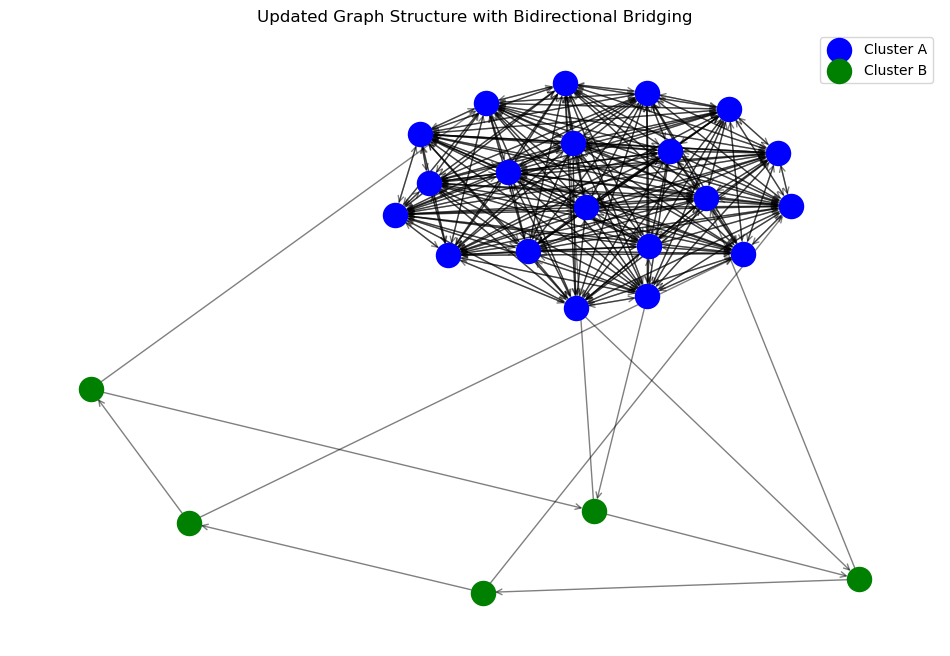

In [20]:
# Create an empty directed graph
G = nx.DiGraph()

# Cluster A: Dense SCC with 20 nodes
cluster_a_nodes = range(1, 21)
G.add_nodes_from(cluster_a_nodes)

# Add edges to make Cluster A strongly connected
for node in cluster_a_nodes:
    for target in cluster_a_nodes:
        if node != target:
            G.add_edge(node, target)

# Cluster B: Sparse component with 5 nodes
cluster_b_nodes = range(21, 26)
G.add_nodes_from(cluster_b_nodes)

# Add sparse edges within Cluster B (forming a ring)
for i in range(len(cluster_b_nodes)):
    G.add_edge(cluster_b_nodes[i], cluster_b_nodes[(i + 1) % len(cluster_b_nodes)])

# Bridging edges from Cluster B to Cluster A
for node in cluster_b_nodes:
    target = random.choice(list(cluster_a_nodes))
    G.add_edge(node, target)

# **New:** Bridging edges from Cluster A to Cluster B
for node in cluster_a_nodes:
    if random.random() < 0.1:  # 10% chance to add an edge to Cluster B
        target = random.choice(list(cluster_b_nodes))
        G.add_edge(node, target)

# Visualize the updated graph structure
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, nodelist=cluster_a_nodes, node_color='blue', label='Cluster A')
nx.draw_networkx_nodes(G, pos, nodelist=cluster_b_nodes, node_color='green', label='Cluster B')
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=10, alpha=0.5)
plt.title('Updated Graph Structure with Bidirectional Bridging')
plt.legend()
plt.axis('off')
plt.show()


In [21]:
# # Create a graph with characteristics where Lazy PageRank converges faster
# # 1. Include dangling nodes
# # 2. Disconnected components
# # 3. Strongly connected clusters

# # Initialize the graph
# G = nx.DiGraph()

# # Add a strongly connected cluster (component 1)
# G.add_edges_from([
#     (1, 2), (2, 3), (3, 4), (4, 1), (2, 4), (3, 1)
# ])

# # Add another strongly connected cluster (component 2)
# G.add_edges_from([
#     (5, 6), (6, 7), (7, 8), (8, 5), (6, 8), (7, 5)
# ])

# # Add dangling nodes connected to cluster 1
# G.add_edges_from([
#     (9, 1), (10, 2)
# ])

# # Add dangling nodes connected to cluster 2
# G.add_edges_from([
#     (11, 5), (12, 6)
# ])

# # Add disconnected nodes (dangling nodes with no outgoing edges)
# G.add_nodes_from([13, 14])

# # Visualize the graph
# pos = nx.spring_layout(G, seed=42)  # Position for consistent layout
# plt.figure(figsize=(10, 8))
# nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=1500, font_size=15)
# plt.title("Graph with Properties Favorable for Lazy PageRank")
# plt.show()


In [22]:
def power_iteration(P, alpha=0.85, max_iter=100, tol=1e-6):
    n = P.shape[0]
    r = np.ones(n) / n  # Initial rank vector
    residuals = []
    for i in range(max_iter):
        r_new = alpha * P.T @ r + (1 - alpha) / n
        residual = np.linalg.norm(r_new - r, 1)
        residuals.append(residual)
        if residual < tol:
            break
        r = r_new
    return r, residuals

def power_iteration_lazy(P, alpha=0.85, lazy_prob=0.5, max_iter=100, tol=1e-6):
    n = P.shape[0]
    r = np.ones(n) / n  # Initial rank vector
    residuals = []
    P_lazy = lazy_prob * np.eye(n) + (1 - lazy_prob) * P
    for i in range(max_iter):
        r_new = alpha * P_lazy.T @ r + (1 - alpha) / n
        residual = np.linalg.norm(r_new - r, 1)
        residuals.append(residual)
        if residual < tol:
            break
        r = r_new
    return r, residuals


In [23]:
# Get the adjacency matrix as a dense numpy array
A = nx.adjacency_matrix(G).astype(float).toarray()
n = A.shape[0]

# Compute row sums
row_sums = A.sum(axis=1)
dangling_nodes = (row_sums == 0)

# Avoid division by zero; replace zeros in row_sums
row_sums_fixed = row_sums.copy()
row_sums_fixed[dangling_nodes] = 1.0

# Normalize to create transition matrix P
P = A / row_sums_fixed[:, np.newaxis]

# For dangling nodes, set rows to uniform probability
P[dangling_nodes, :] = 1.0 / n

# Ordinary PageRank
pr_ordinary, residuals_ordinary = power_iteration(P)

# Lazy PageRank
pr_lazy, residuals_lazy = power_iteration_lazy(P, lazy_prob=0.5)


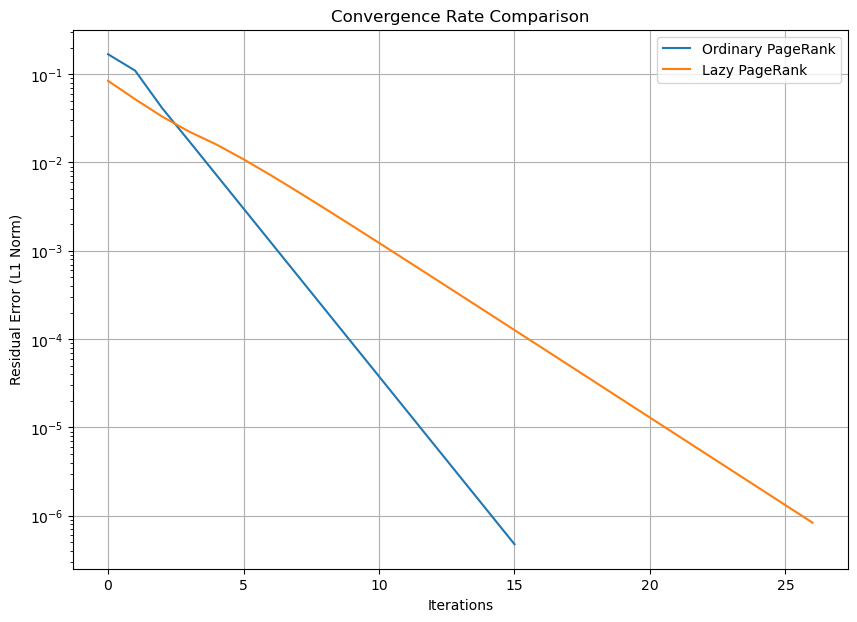

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(residuals_ordinary, label='Ordinary PageRank')
plt.plot(residuals_lazy, label='Lazy PageRank')
plt.xlabel('Iterations')
plt.ylabel('Residual Error (L1 Norm)')
plt.title('Convergence Rate Comparison')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


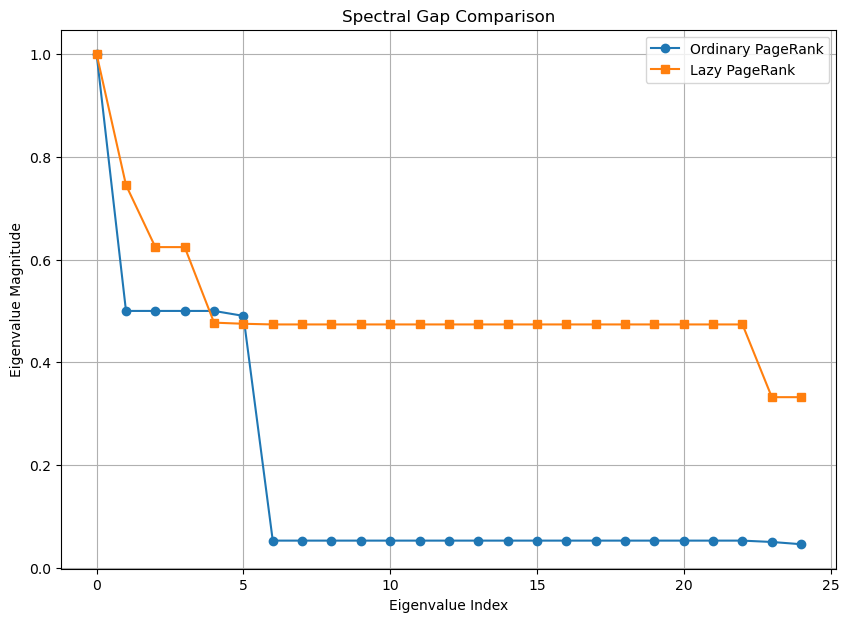

In [25]:
# Ordinary Transition Matrix
eigvals_ordinary = np.linalg.eigvals(P.T)

# Lazy Transition Matrix
P_lazy = 0.5 * np.eye(n) + 0.5 * P
eigvals_lazy = np.linalg.eigvals(P_lazy.T)

# Sort eigenvalues in descending order
eigvals_ordinary = np.sort(np.abs(eigvals_ordinary))[::-1]
eigvals_lazy = np.sort(np.abs(eigvals_lazy))[::-1]

# Plot the eigenvalues
plt.figure(figsize=(10, 7))
plt.plot(eigvals_ordinary.real, marker='o', label='Ordinary PageRank')
plt.plot(eigvals_lazy.real, marker='s', label='Lazy PageRank')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude')
plt.title('Spectral Gap Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
def simulate_hitting_time(G, start_node, target_node, num_simulations=1000, max_steps=1000):
    hitting_times = []
    for _ in trange(num_simulations, desc="Simulating Ordinary Hitting Times"):
        current_node = start_node
        steps = 0
        while current_node != target_node and steps < max_steps:
            steps += 1
            neighbors = list(G.successors(current_node))
            if not neighbors:
                break  # Dead end
            current_node = random.choice(neighbors)
        if current_node == target_node:
            hitting_times.append(steps)
        else:
            hitting_times.append(max_steps)  # Assign max_steps if target not reached
    return np.mean(hitting_times), np.std(hitting_times)

def simulate_hitting_time_lazy(G, start_node, target_node, lazy_prob=0.5, num_simulations=1000, max_steps=1000):
    hitting_times = []
    for _ in trange(num_simulations, desc="Simulating Lazy Hitting Times"):
        current_node = start_node
        steps = 0
        while current_node != target_node and steps < max_steps:
            steps += 1
            if random.random() < lazy_prob:
                continue  # Stay at the same node
            neighbors = list(G.successors(current_node))
            if not neighbors:
                break  # Dead end
            current_node = random.choice(neighbors)
        if current_node == target_node:
            hitting_times.append(steps)
        else:
            hitting_times.append(max_steps)  # Assign max_steps if target not reached
    return np.mean(hitting_times), np.std(hitting_times)


In [27]:
# Function to check mutual reachability
def are_mutually_reachable(G, node1, node2):
    return nx.has_path(G, node1, node2) and nx.has_path(G, node2, node1)

# Select node pairs that are mutually reachable
def select_mutually_reachable_pair(G, cluster_a_nodes, cluster_b_nodes):
    while True:
        node_a = random.choice(list(cluster_a_nodes))
        node_b = random.choice(list(cluster_b_nodes))
        if are_mutually_reachable(G, node_a, node_b):
            return node_a, node_b

# Select a valid node pair
node_a, node_b = select_mutually_reachable_pair(G, cluster_a_nodes, cluster_b_nodes)
print(f"Selected Node A: {node_a} (Cluster A), Node B: {node_b} (Cluster B)")


Selected Node A: 10 (Cluster A), Node B: 23 (Cluster B)


Simulating Ordinary Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Ordinary Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Lazy Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating Lazy Hitting Times:   0%|          | 0/1000 [00:00<?, ?it/s]

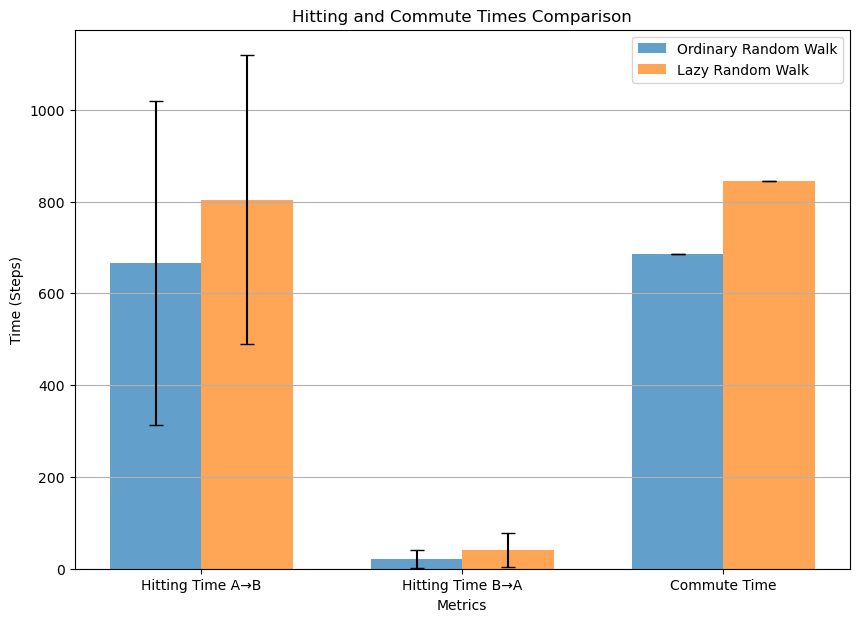

In [28]:
# Compute Hitting and Commute Times

# Ordinary Random Walk
hitting_time_ab_ord, std_ab_ord = simulate_hitting_time(G, node_a, node_b)
hitting_time_ba_ord, std_ba_ord = simulate_hitting_time(G, node_b, node_a)
commute_time_ord = hitting_time_ab_ord + hitting_time_ba_ord

# Lazy Random Walk
hitting_time_ab_lazy, std_ab_lazy = simulate_hitting_time_lazy(G, node_a, node_b, lazy_prob=0.5)
hitting_time_ba_lazy, std_ba_lazy = simulate_hitting_time_lazy(G, node_b, node_a, lazy_prob=0.5)
commute_time_lazy = hitting_time_ab_lazy + hitting_time_ba_lazy

# Prepare Data for Plotting
labels = ['Hitting Time A→B', 'Hitting Time B→A', 'Commute Time']
ordinary_times = [hitting_time_ab_ord, hitting_time_ba_ord, commute_time_ord]
lazy_times = [hitting_time_ab_lazy, hitting_time_ba_lazy, commute_time_lazy]
ordinary_std = [std_ab_ord, std_ba_ord, 0]  # Assuming std for commute_time_ord is negligible
lazy_std = [std_ab_lazy, std_ba_lazy, 0]    # Assuming std for commute_time_lazy is negligible

x = np.arange(len(labels))
width = 0.35  # Width of the bars

# Plotting the Results
plt.figure(figsize=(10, 7))
plt.bar(x - width/2, ordinary_times, width, yerr=ordinary_std, capsize=5, label='Ordinary Random Walk', alpha=0.7)
plt.bar(x + width/2, lazy_times, width, yerr=lazy_std, capsize=5, label='Lazy Random Walk', alpha=0.7)
plt.xlabel('Metrics')
plt.ylabel('Time (Steps)')
plt.title('Hitting and Commute Times Comparison')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y')
plt.show()


Simulating walks starting from Node 25 (Cluster B)


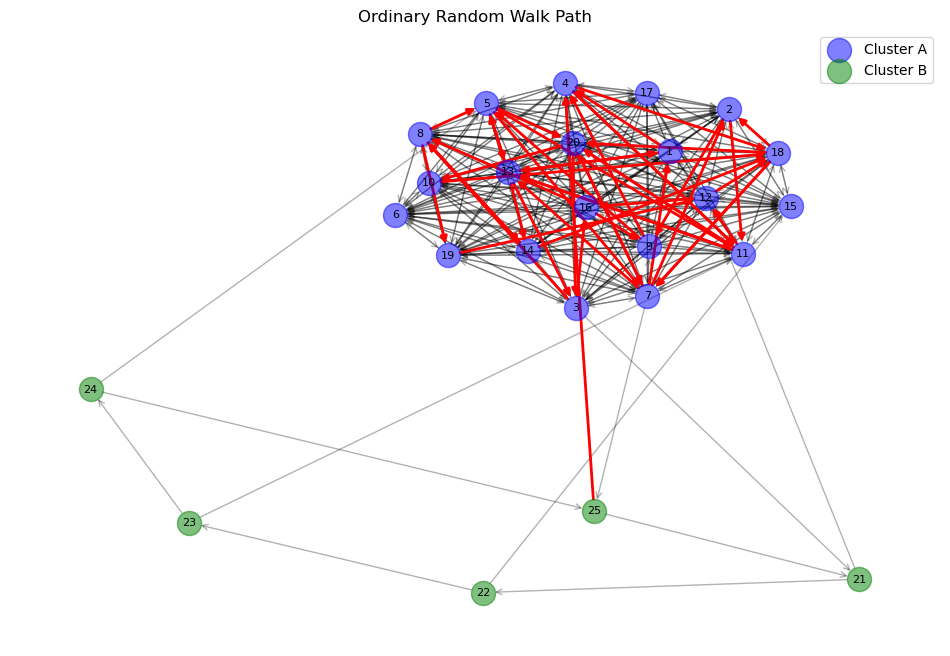

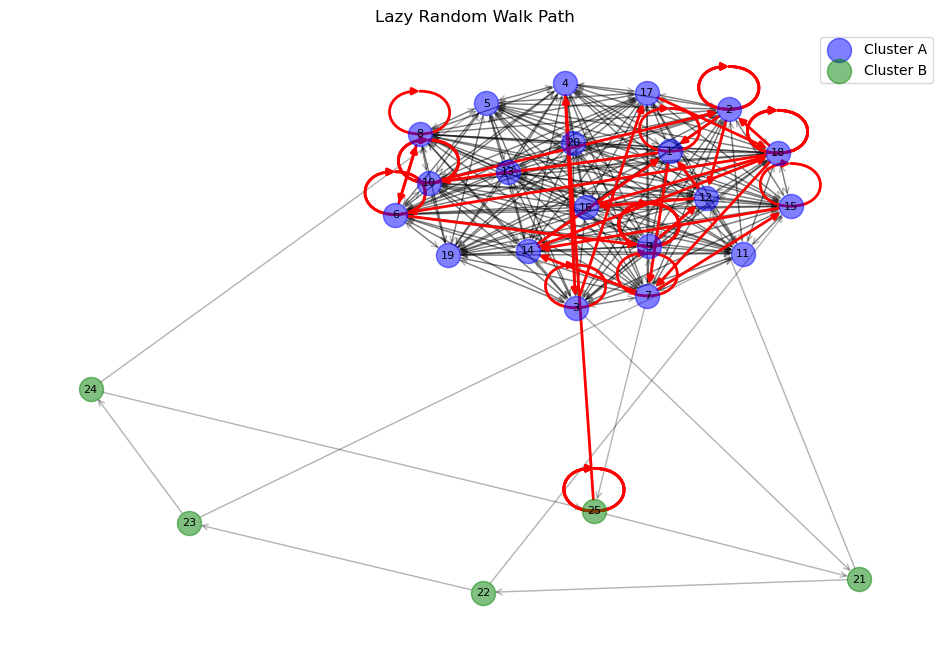

In [29]:
def simulate_random_walk(G, start_node, steps=50):
    path = [start_node]
    current_node = start_node
    for _ in range(steps):
        neighbors = list(G.successors(current_node))
        if not neighbors:
            break
        current_node = random.choice(neighbors)
        path.append(current_node)
    return path

def simulate_random_walk_lazy(G, start_node, lazy_prob=0.5, steps=50):
    path = [start_node]
    current_node = start_node
    for _ in range(steps):
        if random.random() < lazy_prob:
            path.append(current_node)  # Stay at the same node
            continue
        neighbors = list(G.successors(current_node))
        if not neighbors:
            break
        current_node = random.choice(neighbors)
        path.append(current_node)
    return path

# Select a start node from Cluster B
start_node = random.choice(list(cluster_b_nodes))
print(f"Simulating walks starting from Node {start_node} (Cluster B)")

# Simulate Ordinary Random Walk
path_ord = simulate_random_walk(G, start_node)

# Simulate Lazy Random Walk
path_lazy = simulate_random_walk_lazy(G, start_node, lazy_prob=0.5)

# Function to highlight paths on the graph
def plot_walk_path(G, path, title):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, nodelist=cluster_a_nodes, node_color='blue', alpha=0.5, label='Cluster A')
    nx.draw_networkx_nodes(G, pos, nodelist=cluster_b_nodes, node_color='green', alpha=0.5, label='Cluster B')
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='->', arrowsize=10, alpha=0.3)
    # Highlight the path
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2, arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(title)
    plt.legend()
    plt.axis('off')
    plt.show()

# Plotting the paths
plot_walk_path(G, path_ord, 'Ordinary Random Walk Path')
plot_walk_path(G, path_lazy, 'Lazy Random Walk Path')


Why Did Ordinary PageRank Converge Faster in Graph 1?

- **Graph Structure**: The graph had strong connectivity within Cluster A and sparse connectivity in Cluster B, with bidirectional bridging edges.

- **Impact on Random Walks**: In such a graph, the ordinary random walk moves quickly due to high connectivity, especially within Cluster A.

- **Lazy Random Walk Effect**: Introducing laziness (probability of staying at the same node) can slow down the convergence in graphs that are already well-connected because it reduces the movement across nodes.

Why Did Lazy PageRank Converge Faster in Graph 2?

- **Dangling Nodes (9, 10, 11, 12, 13, 14):** Lazy PageRank mitigates the need to redistribute ranks uniformly across the graph, reducing global computation.

- **Disconnected Components ({1, 2, 3, 4} and {5, 6, 7, 8}):** Lazy PageRank keeps rank localized longer within components, accelerating local convergence.

- **Strong Local Clusters:** Nodes within clusters (e.g., {1, 2, 3, 4}) strongly reinforce ranks among themselves, stabilizing faster in Lazy PageRank due to reduced inter-cluster rank dispersion.

- **Reduced Teleportation Effect:** Lazy PageRank limits excessive jumping to unrelated nodes, allowing ranks to stabilize more efficiently in dense substructures.

In a simple random walk on a graph, the transition probability from node $ i $ to node $ j $ is given by the transition matrix $ P $, where $ P_{ij} = \frac{1}{\text{deg}(i)} $ if there is an edge between $ i $ and $ j $, and 0 otherwise. This means that at each time step $ t $, the probability distribution $ \pi_t $ evolves according to:

$
\pi_{t+1} = \pi_t P.
$

In a lazy random walk, the walker has a probability $ \alpha $ of staying at the current node and a probability $ (1 - \alpha) $ of moving to a neighboring node. The transition matrix $ P_{\text{lazy}} $ for the lazy random walk is therefore:

$
P_{\text{lazy}} = \alpha I + (1 - \alpha) P,
$

where $ I $ is the identity matrix. This modification introduces self-loops at each node with probability $ \alpha $.

At time $ t+1 $, the probability distribution $ \pi_{t+1} $ in the lazy random walk evolves as:

$
\pi_{t+1} = \pi_t P_{\text{lazy}} = \alpha \pi_t I + (1 - \alpha) \pi_t P = \alpha \pi_t + (1 - \alpha) \pi_t P.
$

**Observation:** The key difference between the lazy random walk and the simple random walk is the inclusion of the term $ \alpha \pi_t $, representing the probability of the walker staying at the current node. This self-loop slows down the convergence of the walk compared to the simple random walk because the probability distribution changes more gradually over time.

---


Given the PageRank transition matrix:

$
P_g = (1 - p) P + p B,
$

where $ P $ is a stochastic matrix, $ B = \frac{1}{n} \mathbf{1}_{n \times n} $ is a matrix where each entry is $ \frac{1}{n} $, and $ p $ is the damping factor (typically $ p = 0.15 $).

To prove that $ P_g $ remains stochastic, we need to show two things:

1. **Non-negativity:** All entries of $ P_g $ are non-negative.
2. **Row sums equal to 1:** The sum of each row in $ P_g $ is 1.

**Proof:**

1. **Non-negativity:**
   - Since $ P $ is stochastic, $ P_{ij} \geq 0 $ for all $ i, j $.
   - Since $ B_{ij} = \frac{1}{n} \geq 0 $ for all $ i, j $.
   - The coefficients $ (1 - p) $ and $ p $ are non-negative (since $ p \in [0,1] $).
   - Therefore, $ P_g $ entries are non-negative:
     $
     P_g[i][j] = (1 - p) P[i][j] + p B[i][j] \geq 0.
     $

2. **Row sums equal to 1:**
   - For each row $ i $:
     $
     \sum_{j} P_g[i][j] = (1 - p) \sum_{j} P[i][j] + p \sum_{j} B[i][j].
     $
   - Since $ P $ is stochastic:
     $
     \sum_{j} P[i][j] = 1.
     $
   - Since $ B[i][j] = \frac{1}{n} $:
     $
     \sum_{j} B[i][j] = n \times \frac{1}{n} = 1.
     $
   - Therefore:
     $
     \sum_{j} P_g[i][j] = (1 - p)(1) + p(1) = 1.
     $

**Conclusion:** Since $ P_g $ has non-negative entries and each row sums to 1, $ P_g $ remains a stochastic matrix.